In [1]:
import periodictable
from Bio.PDB import PDBParser
from refnx.reflect import SLD, Slab, Structure, ReflectModel
import MDAnalysis as md
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
import re

import refnx, scipy
# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset
from refnx.reflect import reflectivity
# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import ReflectModel, SLD, Stack
# the analysis module contains the curvefitting engine
from refnx.analysis import Objective, Transform, CurveFitter

from md_simulation import MDSimulation

import warnings
warnings.filterwarnings('ignore')

See this for help: https://nbviewer.org/github/refnx/refnx-models/blob/master/md_simulation/md_simulation.ipynb 


For some background knowledge: http://gisaxs.com/index.php/Scattering_Length_Density#:~:text=The%20Scattering%20Length%20Density%20(SLD,of%20the%20'scattering%20entities'

And here_: https://periodictable.readthedocs.io/en/latest/guide/intro.html

In [ ]:
def strip_end(string):
    """
    Strips 'R', 'S', or 'T' from the end of a string if the string has more than 4 characters.
    
    Args:
        string (str): The input string.
        
    Returns:
        str: The stripped string.
    """
    if len(string) > 4:
        while string.endswith(('R', 'S', 'T')):
            string = string[:-1]
    
    return string



#### Extracts the SLD values for each atom type in the universe

In [ ]:
# Load trajectory and topology
u = mda.Universe("lipids.gro", "whole.xtc")
# sub_uni = u.select_atoms('resname TIP3')

# with mda.Writer("sub.xtc", sub_uni.n_atoms) as W:
#     for ts in u.trajectory:
#         W.write(sub_uni)
# sub_uni.atoms.write('sub.pdb')

# u = mda.Universe('sub.pdb', 'sub.xtc')


# with mda.Writer("output.pdb", multiframe=True) as pdb_writer:
#     for ts in u.trajectory:
#         # Write the coordinates of the current frame to the PDB file
#         pdb_writer.write(u.atoms)


# # Step 1: Extract atom positions and information from MDAnalysis Universe
# atom_positions = u.atoms.positions  # Numpy array of shape (n_atoms, 3)
# atom_types = u.atoms.names  # List of atom names

# # Calculate SLD values for each atom in the current frame
sld_values_1 = [periodictable.elements.symbol(atom.type).neutron.sld(wavelength=1.798)[:-1] for atom in u.atoms] 
# #(*real*, -*imaginary*, *incoherent*) I do not consider the incoherent


 # Step 2: Define the SLD values for each atom type
sld_values = {}
out = open('simulation.lgt', 'w')
for atom, sld in zip(u.atoms.names, sld_values_1):
    ### If you use a pdb file instead, you need to strip the R, T, and S in the end, cause the names can only be 4 spaces long
    # sld_values[strip_end(atom)] = sld
    # out.write(f"{strip_end(atom)} {sld[0]} {sld[1]}\n") 
    sld_values[atom] = sld
    out.write(f"{atom} {sld[0]} {sld[1]}\n")

out.close()


# For atomistic systems 
You may need to change manually what is deutuared

now working with layers
now working with layers
now working with layers


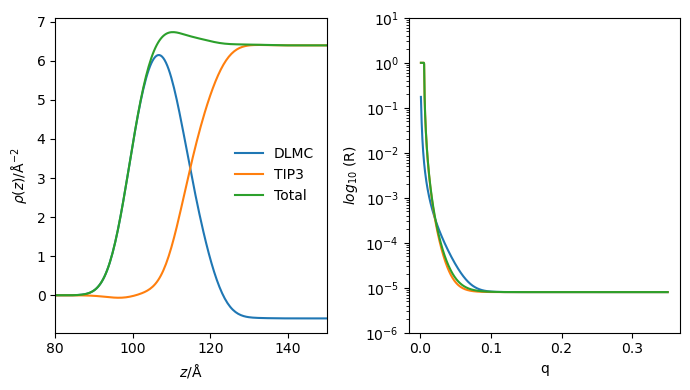

In [5]:
u = md.Universe("step7_0.gro", "step7_0.part0002.xtc")
sub_uni = u.select_atoms('all and not resname SOD CLA')

with md.Writer("sub.xtc", sub_uni.n_atoms) as W:
    for ts in u.trajectory:
        W.write(sub_uni)
sub_uni.atoms.write('sub.pdb')

##Reload trajectory
u = md.Universe('sub.pdb', 'sub.xtc')

# list of atoms to be kept as hydrogenous in the mc3 lipid 
mc3_H_atoms = 'HN11 HN12 HN13 HN21 HN22 HN23 H11 H12 H21 H22 H31 H32 H5\
                H11R H11S H12R H12S'

# for charged mc3
mc3_H_atoms = 'HN4 HN11 HN12 HN13 HN21 HN22 HN23 H11 H12 H21 H22 H31 H32 H5\
                H11R H11S H12R H12S'

keep_H = mc3_H_atoms + mc3_H_atoms

# for polyA
polyA_H_atoms = "H61 H62"


fig, ax = plt.subplots(ncols=2, figsize=(7,4))

#for resname in np.unique(u.select_atoms('all').resnames):
for resname in ['DLMC', 'TIP3', 'Total']:
	u = md.Universe('sub.pdb', 'sub.xtc')
	if resname  == 'DLMC':
		keep_H =  mc3_H_atoms + mc3_H_atoms
		#print (f'resname {resname} and type H and not name {keep_H}')
		u.select_atoms(f'resname {resname} and type H and not name {keep_H}').atoms.types = 'D'
	if resname == 'ADE':
		keep_H = polyA_H_atoms
		#print (f'resname {resname} and type H and not name {keep_H}')
		u.select_atoms(f'resname {resname} and type H and not name {keep_H}').atoms.types = 'D'
	if resname == 'Total':
		u.select_atoms('all and type H').atoms.types = 'D'
	else:
		#print (f'resname {resname} and type H')
		u.select_atoms(f'resname {resname} and type H').atoms.types = 'D'

	
	sim = MDSimulation(u,flip=False, cut_off=137, layer_thickness=1, roughness=3.5)
    # The cutoff is half the box dimensions. To make sure, only one monolayer is considered. 
    
	# this is just one of three ways to determine the scattering lengths
	sim.assign_scattering_lengths('neutron')
	sim.run()
	
	np.save(f'SLD_{resname}.npy', sim.sld_profile())
	ax[0].plot(sim.sld_profile()[0], sim.sld_profile()[1]*10, label=resname)
	ax[0].set_xlabel('$z$/Å')
	ax[0].set_ylabel(r'$\rho(z)$/Å$^{-2}$')


	"""
	generate reflectivity from MD-SLD with refnx 
	"""
	
	# changing to refnx notation for clarity 
	structure = sim.sld_profile()[1]
	
	# define roughness of each layer 
	roughness = 3.5
	thickness = 1.0
	
	# define imaginary SLD component 
	SLD_im = 0
	
	# define x (q) and y (R) variables 
	q = np.linspace(0.001,0.35,int(1e3))
	
	  
	# define empty array for populating with individual slab layers 
	slabs = []
	
	# generate slabs for each structure 
	for SLD_re in structure:
	    slabs.append([thickness, SLD_re, SLD_im, roughness])
	
	# convert to array for refnx processing 
	slabs = np.array(slabs)
	
	# calculate and store reflectivity 
	R = list( reflectivity(q,slabs,bkg=8.0e-6) )
	np.save(f'Reflectivity_{resname}.npy', R)
	ax[1].plot(q,R)
    


ax[0].legend(loc='best', frameon=False)
ax[0].set_xlim(80,150)
ax[1].set_ylabel('$log_{10}$ (R)')
ax[1].set_xlabel('q')
ax[1].set_yscale('log')
ax[1].set_ylim(10**-6, 10)
#ax[1].axhline(y=1, xmin=0, xman=0.3)
#ax[1].set_xlim(0,0.0004)

plt.tight_layout()

plt.savefig('SLD_Ref_profile_AA.png', dpi=300, bbox_inches='tight')

In [ ]:
u.dimensions

# For CG systems

In [6]:
Martini_SLD_values = {'NC3':-0.5158,
                      'PO4': 2.672,
                      'GL' : 1.88805,
                      'C'  : -0.3332,
                      'D'  : 0.4152,
                      'W'  : -0.672} ## Unit is in 10**-6 cm !!
## From paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7587404/ 
## In SI
## Essentially we can just sum up the SLD values for each atom in the bead

## Needs adaptation to the ILs
## Essentially, we just sum up the SLD values for the atoms in each bead

In [3]:
pwd

'/scratch/kmzh811/kmzh811/RNA_MC3_monolayers/AA'

In [7]:
#From Sams script
#Atom SLD values
SLD_dir = {
            "H": -3.739,
            "D": 6.67,
            "C": 6.646,
            "N": 9.36,
            "O": 5.803,
            "P": 5.10,}

In [27]:
# Open the mapping index file
# It contains the atom names for each bead type in the lipid
mapping = open('/projects/cp/user/kmzh811/PYTHON/M3-Ionizable-Lipids/Collection_of_itps/Literature_known_ILs/MC3H/Mapping/mapping.ndx','r').readlines()

bead_dir = {}
for idx, line in enumerate(mapping):
    #print (line)
    if re.match('\[', line):
        bead_name = line.split()[0].strip('\[').strip('\]')
        atom_list = mapping[idx+1].split()
        SLDs = 0 
        for a in atom_list:
            a_type = a[0]
            #get SLD values to the type 
            #SLD = periodictable.elements.symbol(a_type).neutron.sld(wavelength=1.798)[0]#only considering the real
            ## Not sure about the units taken from periodictable. Maybe its just a conversion factor
            SLD = SLD_dir[a_type]
            SLDs += SLD
        bead_dir[bead_name] = SLDs
        ## Deuturate the tails. Change H into D for each bead starting with C or D
        if bead_name[0] == 'C' :
            for a in atom_list:
                if a[0] == 'H':
                    a_type = 'D'
                else:
                    a_type = a[0]
                SLDs += SLD_dir[a_type]
            bead_dir[bead_name+'d'] = SLDs

In [28]:
bead_dir['W'] = 2*SLD_dir['H'] + SLD_dir['O']
bead_dir['D'] = 2*SLD_dir['D'] + SLD_dir['O']

In [29]:
bead_dir

{'N1': -3.521000000000001,
 'CN': -1.6639999999999988,
 'CNd': 38.30800000000001,
 'GLA': 17.419999999999998,
 'CX': 1.2429999999999968,
 'CXd': 54.531000000000006,
 'C1A': -4.160000000000007,
 'C1Ad': 95.77000000000001,
 'D2A': 4.149999999999997,
 'D3A': 4.149999999999997,
 'C4A': -7.067000000000003,
 'C4Ad': 79.54700000000001,
 'C1B': -4.160000000000007,
 'C1Bd': 95.77000000000001,
 'D2B': 4.149999999999997,
 'D3B': 4.149999999999997,
 'C4B': -3.328000000000003,
 'C4Bd': 76.616,
 'W': -1.6749999999999998,
 'D': 19.143}

In [20]:
bead_dir ## You need to add POPC and  CHOL of course 

{'N1': 6.84197772173972,
 'CN': 8.337640973402396,
 'CNd': 48.3096409734024,
 'GLA': 16.484287100336903,
 'CX': 14.088895632507242,
 'CXd': 67.37689563250724,
 'C1A': 20.84410243350598,
 'C1Ad': 120.774102433506,
 'D2A': 19.840150291612087,
 'D3A': 19.840150291612087,
 'C4A': 15.092847774401124,
 'C4Ad': 101.70684777440114,
 'C1B': 20.84410243350598,
 'C1Bd': 120.774102433506,
 'D2B': 19.840150291612087,
 'D3B': 19.840150291612087,
 'C4B': 16.675281946804777,
 'C4Bd': 96.61928194680479,
 'W': -1.6749999999999998,
 'D': 19.143}

#### Next step is making a file with the SLD information per bead

In [21]:
#Load in universe 
u = md.Universe('../r.gro', '../r.xtc')
no_ions = u.select_atoms('all and not name NA CL and not resname NA CL')
with md.Writer("no_ions.xtc", no_ions.n_atoms) as W:
    for ts in u.trajectory:
        W.write(no_ions)
no_ions.atoms.write('no_ions.pdb')


uni = md.Universe('no_ions.pdb', 'no_ions.xtc')

In [30]:
# Step 2: Define the SLD values for each atom type
sld_values = {}
scattering_lengths = []
out = open('simulation_CG.lgt', 'w')
beads = []
for atom in uni.atoms.names:
    if atom == 'CL':
        continue
    elif atom == 'NA':
        continue
    else:
        sld_value = bead_dir[atom] ### How to take the deuturaret values if needed? 
        out.write(f"{atom} {sld_value} 0\n") #imaginary is just set to 0 here
        #out.write(f"{sld_value} 0\n")
        beads.append(atom)
        scattering_lengths.append([sld_value,0])
out.close()

In [23]:
pwd

'/scratch/kmzh811/kmzh811/RNA_MC3_monolayers/AA'

now working with layers


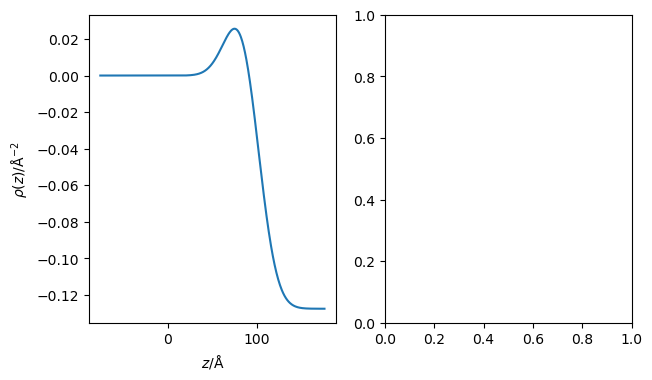

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(7,4))

	
sim = MDSimulation(uni, cut_off=137, layer_thickness=5, roughness=3.5, flip=True)
# The cutoff is half the box dimensions. To make sure, only one monolayer is considered. 

sim.assign_scattering_lengths('neutron', lgtfile='simulation_CG.lgt')

sim.run()
	
ax[0].plot(sim.sld_profile()[0], sim.sld_profile()[1]*10, label='CG')
ax[0].set_xlabel('$z$/Å')
ax[0].set_ylabel(r'$\rho(z)$/Å$^{-2}$')
plt.savefig('SLD_CG.png', dpi=300, bbox_inches='tight')

In [14]:
sim.av_layers.shape

(21, 5)

In [15]:
sim.layers.shape

(10001, 50, 5)

In [16]:
sim.slabs().shape

(21, 5)

Text(0, 0.5, '$\\rho(z)$/Å$^{-2}$')

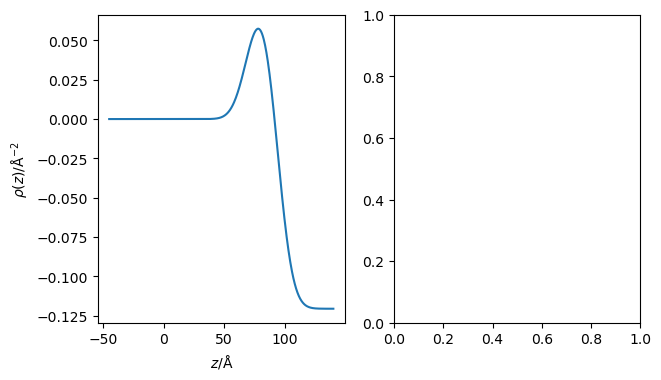

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(7,4))

ax[0].plot(sim.sld_profile()[0], sim.sld_profile()[1]*10, label='CG')
ax[0].set_xlabel('$z$/Å')
ax[0].set_ylabel(r'$\rho(z)$/Å$^{-2}$')

## thickness set to 5 